# LW Profile and Statistics Plots for RRTMGP Band Generation

## Necessary Libraries

In [1]:
# standard libraries
import os, sys
import datetime as DT

# pip install
import numpy as np
import matplotlib.pyplot as plot
from matplotlib import rc
import matplotlib.font_manager as font
import netCDF4 as nc
import time # for process_timeing processes

# for multi-page PDF files
from matplotlib.backends.backend_pdf import PdfPages

# Pernak Python module
LIBPATHS = ['common']
for path in LIBPATHS: sys.path.append(path)
import utils

## Global Variables

These variables will likely not to be changed for various runs of the `main()` code. So after this cell is run once, it will probably not need to be run again.

In [2]:
# this changes with netCDF template version -- 
# older versions use 'band_wavenumbers', newer ones use 'band_lims_wvn'
# indexing for these arrays may also be reversed depending on version
BWVN = 'band_lims_wvn'

# default attributes to extract from input netCDFs
DEFATTR = ['dimensions', BWVN, 'emis_sfc', 'p_lay', \
  'p_lev', 't_lay', 't_lev', 't_sfc', 'vmr_h2o', 'vmr_co2', \
  'vmr_o3', 'vmr_ch4', 'vmr_co', 'vmr_n2o', 'vmr_o2', 'vmr_n2']

# trial and error spacing for subplots
HSPACE = 0.5

IRECORD = 0

## Function Definitions

Again, this large cell should only need to be run once, as no edits from end users are anticipated.

In [3]:
def getVars(ncFile, attrList=DEFATTR, configDesc=None, flipNet=False):
  """
  Reads in netCDF file and returns a dictionary with the specified
  netCDF attributes

  Call
    outDict = getVars(ncFile, attrList=DEFATTR)
  Input
    ncFile -- string, path to netCDF file
  Returns
    outDict -- dictionary with keys that correspond to attributes in
      attrList and the associated values from ncFile; also includes a
      model description key (for whatever model was used to generate
      ncFile)
  Keywords
    attrList -- list of strings that are names of desired netCDF
      attributes
    configDesc -- string, model description from the input
      configuration file, which supercedes the model description in
      the netCDF global attributes
    flipNet -- boolean; flip the sign of net fluxes for LBLRTM
  """

  # create netCDF object
  print('Reading %s' % ncFile)
  ncObj = nc.Dataset(ncFile, 'r')

  # initialize output (this dictionary is dynamic and
  # dependent on attrList)
  outDict = {}
  # Handling LBLRTM net change outside of python now
  flipNet=False
  for attr in attrList:
    # for default, only "dimensions" will not be processed
    if not attr in ncObj.variables.keys(): continue

    if (attr == 'p_lev') or (attr == 'p_lay'):
      # Pa to mbar conversion
      outDict[attr] = np.array(ncObj.variables[attr][IRECORD]) / 100.0
    elif 'heating_rate' in attr:
      # K/s to K/day conversion
      outDict[attr] = np.array(ncObj.variables[attr][IRECORD]) * 86400
    #elif 'flux_net' in attr and 'lblrtm' in ncFile and flipNet:
    #  # flip the LBLRTM flux for Jen
    #  outDict[attr] = np.array(ncObj.variables[attr]) * -1
    else:
      outDict[attr] = np.array(ncObj.variables[attr][IRECORD])
  # end loop over attributes

  if configDesc is None:
    mdKey = 'model-description'
    if mdKey in ncObj.ncattrs():
      # put in some new lines where appropriate for readability
      modDesc = ncObj.getncattr(mdKey).replace(',', '\n')
      modDesc = modDesc.replace('/', '/\n')
    else:
      modDesc = ''
    # end model description
  else:
    modDesc = str(configDesc)
  # end configFdesc
  outDict[mdKey] = modDesc

  ncObj.close()

  return outDict
# end getVars()

def plotProfiles(refVar, testVar, ordinate, plotDelta=False, \
  pTitle='', xTitle='', yTitle='', tPauseP=100.0, plotMean=False, \
  yLog=False):

  """
  Single case of what is done in profPDFs
  Call
    plotProfiles(refVar, testVar, ordinate, plotDelta=False, \
      pTitle='', xTitle='', yTitle='', tPauseP=100.0)
  Input
    refVar -- float array, abscissa values for reference model
    testVar -- float array, abscissa values for test model
    ordinate -- float array, y values for plot (probably pressure)
  Output
  Keyword
    plotDelta -- boolean, plots test-ref differences instead of
      overplotting both
    pTitle -- string, title for plot panel
    xTitle, yTitle -- strings, titles for x and y axes
    tPauseP -- float, tropopause pressure threshold (mbar)
    yLog -- boolean, plot ordinate axis on log scale instead of linear
  """

  if plotDelta:
    dVar = testVar-refVar
    plot.plot(dVar, ordinate, 'k')
    plot.xticks(rotation=15)
    plot.ylim(0.1, 1050.)

    # mark the zero-difference and tropopause lines
    plot.vlines(0, ordinate.min(), ordinate.max(), linestyle='dotted')
    plot.hlines(tPauseP, dVar.min(), dVar.max(), linestyle='dotted')
  elif plotMean:
    dVar = np.array(refVar)
    plot.plot(dVar, ordinate, 'k')
    plot.xticks(rotation=15)
    plot.ylim(0.1, 1050.)

    # mark the zero-difference and tropopause lines
    plot.vlines(0, ordinate.min(), ordinate.max(), linestyle='dotted')
    plot.hlines(tPauseP, min(dVar), max(dVar), linestyle='dotted')
  else:
    plot.plot(testVar, ordinate, 'b', refVar, ordinate, 'r')
    plot.xticks(rotation=15)
    plot.ylim(0.1, 1050.)

    # legend in top-left panel only
    if ('Upward' in pTitle) and ('Flux' in xTitle):
      # for smaller legend fonts
      font_prop = font.FontProperties()
      font_prop.set_size(8)
      plot.legend(['Test', 'Reference'], loc='best', prop=font_prop)
    # end legend
  # end plotDelta

  if yLog: plot.semilogy()
  plot.title(pTitle)
  plot.xlabel(xTitle)
  plot.ylabel(yTitle)

  # get current axes and flip pressure
  ax = plot.gca()
  ax.invert_yaxis()

# end plotProfiles()

def profPDFs(ref, test, deltaStr, outDir='.', \
  shortWave=False, tPauseP=100.0, broadOnly=False, \
  prefix='PROFS_sens_key_cnt_add_min_04_dbl_r472_trynewn2opres', \
  atmType='Garand Atmospheres', inBand=None, **kwargs):

  """
  Plot upward flux, downward flux, and heating rate as well as the
  test-ref difference for each of those three variables on a single
  page (3x2 array of figures) for each column and band specified in
  ref and test. Fluxes and HR are plotted as functions of pressure,
  so we are plotting profiles.
  Call
    profPDFs(ref, test, outDir='.', shortWave=False, \
      prefix='PROFS_sens_key_cnt_add_min_04_dbl_r472_trynewn2opres')
  Input
    ref -- string, path to netCDF for reference model
    test -- string, path to netCDF for test model
    deltaStr -- string, something like 'test-reference'
  Output
    prefix_band.pdf in outDir for all bands provided
      in ref and test
  Keywords
    outDir -- string, top level directory for output figures
    shortWave -- boolean, specifies that short-wave radiation flux
      units should be specified in axis labels
    tPauseP -- float, tropopause pressure threshold (mbar)
    broadOnly -- boolean, only generate a broadband plot
    prefix -- string that will be placed in front of the band
      number in the name of the output PDF file
    atmType -- float, atmosphere type (e.g., Garand)
    inBand -- int, band number (default is all)
    **kwargs -- overloaded arguments
      logy -- boolean, plots with a log-y axis rather than linear
  """

  # get the output for plotting
  plotVars = ['band_flux_up', 'band_flux_dn', 'band_heating_rate', \
    'p_lay', 'p_lev', BWVN]
  plotTitle = ['Upward Flux', 'Downward Flux', 'Heating Rate', \
    'Pressure (mbar)', 'Pressure (mbar)', 'Wavenumber Range']
  dum = plotVars[1]
  refDict = getVars(refFile, attrList=plotVars)
  testDict = getVars(testFile, attrList=plotVars)
  # some quality control (consistency check)
  if refDict[dum].shape != testDict[dum].shape:
    sys.exit('%s and %s do not have equal dimensions, returning' % \
      refFile, testFile)

  # grab dimensions of variables
  varShape = refDict[dum].shape
  nBand = varShape[2]; nCol = varShape[1]

  # broadband fluxes initialization
  broadDictRef, broadDictTest = {}, {}
  for pVar in plotVars[:3]:
    broadDictRef[pVar] = None
    broadDictTest[pVar] = None
  # end broadband initialize

  # if inBand is not specified, cover all bands and include a
  # broadband page
  bandList = range(nBand+1) if inBand is None else [inBand]
  for band in bandList:
    print('Band %d' % (band+1))

    # broadband integration -- each key is initialized and incremented
    # together for ref and test (so ref 'up' conditional should
    # suffice rather than a conditional for all ref and test keys)
    # perhaps a more Pythonic way to do this?
    if (broadDictRef['band_flux_up'] is None):
      for pVar in plotVars[:3]:
        broadDictRef[pVar] = refDict[pVar][:, :, band]
        broadDictTest[pVar] = testDict[pVar][:, :, band]
      # end broadband assign
    else:
      for pVar in plotVars[:3]:
        # no further increments needed if in the broadband iteration
        if (band == nBand) and (nBand > 1): break
        broadDictRef[pVar] += refDict[pVar][:, :, band]
        broadDictTest[pVar] += testDict[pVar][:, :, band]
      # end broadband increment
    # endif broadband

    if broadOnly and (band < nBand): continue

    # make 1 PDF per band
    if (band == nBand) and (nBand > 1):
      # broadband page
      outFile = '%s/%s_broadband.pdf' % (outDir, prefix)
      wnRange = [refDict[BWVN][0, 0],
                 refDict[BWVN][nBand-1, 1]]
    else:
      outFile = '%s/%s_%02d.pdf' % (outDir, prefix, band+1)
      wnRange = refDict[BWVN][band, :]
    # endif broadband

    pdf = PdfPages(outFile)

    t1 = time.process_time()

    # "a" column stands for atmospheric column
    for aCol in range(nCol + 1):
      # plot 1 atm column per page, 3x2 array of subfigures
      print('Column %d of %d' % (aCol+1, nCol))

      colStr = 'Mean' if (aCol == nCol) else '%d' % (aCol+1)
      colStr = 'Column %s' % colStr
      bandStr = 'Broadband' if (band == nBand) and (nBand > 1) else \
        'Band %d' % (band+1)
      figTitle = '%s %s, %s (%.0f-%.0f cm$^{-1}$)' % \
        (atmType, colStr, bandStr, wnRange[0], wnRange[1])

      fig = plot.figure()
      fig.set_size_inches(8.5, 11)
      fig.suptitle(figTitle, fontweight='bold')

      # try to center the timestamp on the bottom
      fig.text(0.45, 0.01, \
        DT.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), \
          multialignment='center')

      ctr = 1

      # space between plots
      plot.subplots_adjust(hspace=HSPACE, wspace=HSPACE)

      # now loop over subplot rows and columns
      # (iCol is index of subplot column)
      for iRow in range(3):
        pVar = plotVars[iRow]
        pTitle = plotTitle[iRow]
        for iCol in range(2):
          plot.subplot(3, 2, ctr)

          # fluxes are by level, heat rate are by layer
          pOrd = refDict['p_lay'] if iRow == 2 else refDict['p_lev']
          nP = pOrd.shape[0]

          # some other plotting params
          delta = True if iCol % 2 == 1 else False
          if 'Flux' in pTitle:
            units = '[W m$^{-2}$]' if shortWave else '[W m$^{-2}$]'
            tempVar = 'Flux'
          else:
            units = '[K day$^{-1}$]'
            tempVar = 'HR'
          # end units and tempVar

          if delta:
            xt = '%s %s Difference %s' % (deltaStr, tempVar, units)
            yt = ''
          else:
            xt = '%s %s' % (tempVar, units)
            yt = 'Pressure [mbar]'
          # end delta

          if (aCol == nCol):
            mean_refDict = {pVar: []}
            mean_testDict = {pVar: []}
            mean_resDict = {pVar: []}

            # broadband or single band column averaging?
            if band == nBand:
              testArr = broadDictTest[pVar][:, :]
              refArr = broadDictRef[pVar][:, :]
            else:
              testArr = testDict[pVar][:, :, band]
              refArr = refDict[pVar][:, :, band]
            # end broadband check

            for iP in range(nP):
              test_mean = np.mean(testArr[iP, :])
              test_sdev = np.std(testArr[iP, :])
              ref_mean = np.mean(refArr[iP, :])
              ref_sdev = np.std(refArr[iP, :])
              res_diff = testArr[iP, :] - refArr[iP, :]
              res_mean = np.mean(res_diff)
              res_sdev = np.std(res_diff)
              mean_testDict[pVar].append(test_mean)
              mean_refDict[pVar].append(ref_mean)
              mean_resDict[pVar].append(res_mean)
            # end pressure loop

            if delta:
              plotProfiles(mean_resDict[pVar], \
                mean_testDict[pVar], pOrd[:, aCol-1], \
                pTitle=pTitle, xTitle=xt, yTitle=yt, plotMean=1, \
                yLog=kwargs['yLog'])
            else:
              plotProfiles(mean_refDict[pVar], \
                mean_testDict[pVar], pOrd[:, aCol-1], \
                pTitle=pTitle, xTitle=xt, yTitle=yt, \
                plotDelta=False, plotMean=False, yLog=kwargs['yLog'])
            # endif delta

          else:
            if (band == nBand) and (nBand > 1):
              plotProfiles(broadDictRef[pVar][:, aCol], \
                broadDictTest[pVar][:, aCol], pOrd[:, aCol], \
                pTitle=pTitle, xTitle=xt, yTitle=yt, \
                plotDelta=delta, yLog=kwargs['yLog'])
            else:
              plotProfiles(refDict[pVar][:, aCol, band], \
                testDict[pVar][:, aCol, band], pOrd[:, aCol], \
                pTitle=pTitle, xTitle=xt, yTitle=yt, \
                plotDelta=delta, yLog=kwargs['yLog'])
            # endif broadband
          # endif mean plot

          ctr += 1
        # end iCol loop
      # end iRow loop

      # write page for column
      pdf.savefig()
      plot.close()
      #plot.show()
      #sys.exit()
    # end aCol loop
    pdf.close()

    print(time.process_time() - t1)
    print('Processed band %d' % (band+1))

  # end band loop
# end profPDFs()

def plotStats(residuals, reference, rmsArr, pdf='temp.pdf', \
  figTitle='Garand Atmospheres', shortWave=False, pdfObj=None, \
  xTitle='LBLRTM', yTitle='RRTMGP - LBLRTM', forcing=True):
  """
  Plot each array in the dictionaries generated with statPDF() in a
  separate panel and calculate statistics for each panel
  Call
    plotStats(residuals, reference, rmsArr, pdf='temp.pdf', \
      figTitle='Garand Atmospheres', shortWave=False)
  Input
    residuals -- dictionary, each key in dictionary corresonds to
      the RRTMGP-LBLRTM differences for a given variable as calculated
      in statPDF() (in addition to the model description keys)
    reference -- dictionary, has same keys as residuals, but the
      associate values (arrays) contain only the corresponding LBLRTM
      calculations
    rmsArr -- float array, RMS values for each plotting parameter
      for all levels and all columns for a given band; should be
      [TOA Up Flux, SFC Down Flux, Max Net Flux, Trop HR, Strat HR]
  Output
    see pdf keyword
  Keywords
    pdf -- string, path to output PDF
    figTitle -- string, title for entire figure (not subplots)
    shortWave -- boolean, specifies that short-wave radiation flux
      units should be specified in axis labels
    pdfObj -- PdfPages object, to which we send the STATS plots
      (only use with the singlePDF option in statPDF())
    xTitle -- string, label for x-axis (unitless)
    yTitle -- string, label for y-axis (unitless)
    forcing -- boolean, if set, plot the 5% and 10% error lines on
      all plots rather than the 1 (tropospheric HR) plot if this
      keyword is not set
  """

  # set figure title and size
  fig = plot.figure()
  fig.set_size_inches(8.5, 11)
  fig.suptitle(figTitle, fontweight='bold')

  # universal font size for this page
  font = {'size': 8}
  rc('font', **font)

  # for zero line and 5, 10% err lines
  mSize = 0.5; oPlotSym = 'k:'

  # space between plots was done with trial and error
  plot.subplots_adjust(hspace=HSPACE, wspace=HSPACE)
  for key in reference.keys():
    if key == 'band_flux_up':
      iPlot = 1
      title = 'TOA Upwelling Flux'
    elif key == 'band_flux_dn':
      iPlot = 2
      title = 'Surface Downwelling Flux'
    elif key == 'band_flux_net':
      iPlot = 3
      title = 'Maximum Net Flux'
    elif key == 'band_heating_rate_trop':
      iPlot = 4
      title = 'Maximum Tropospheric HR'
    elif key == 'band_heating_rate_strat':
      iPlot = 5
      title = 'Maximum Stratospheric HR'
    else: continue
    # end plot param assignment

    plot.subplot(3, 2, iPlot)
    ref = reference[key]; res = residuals[key]
    xZeros = np.array([min(ref), max(ref)])
    for ctr, delta in enumerate(res):
      # plot points should be black numbers corresponding to
      # column number
      plot.plot(ref[ctr], delta, 'k', \
        marker='$%d$' % (ctr+1), markersize=10)
      plot.xticks(rotation=15)
    # end subplot

    plot.hlines(0, xZeros[0], xZeros[1], linestyle='dotted')
    # overplot 5% and 10% error lines (+/-)
    errPlots = range(1, 6) if forcing else [4, 5]
    if iPlot in errPlots:
      # make a y = ax line for each threshold
      err5 = np.poly1d([0.05, 0]); err10 = np.poly1d([0.10, 0])
      plot.plot(xZeros, err5(xZeros), oPlotSym, markersize=mSize)
      plot.plot(xZeros, err10(xZeros), oPlotSym, markersize=mSize)

      err5 = np.poly1d([-0.05, 0]); err10 = np.poly1d([-0.10, 0])
      plot.plot(xZeros, err5(xZeros), oPlotSym, markersize=mSize)
      plot.plot(xZeros, err10(xZeros), oPlotSym, markersize=mSize)
    # end error lines

    # plot title contains residual statistics for all columns
    meanErr = np.mean(res); sdErr = np.std(res, ddof=1)
    meanAbsErr = np.mean(np.abs(res))
    sdAbsErr = np.std(np.abs(res), ddof=1)
    mu = r'$\mu$'; sigma = r'$\sigma$'
    title += \
      '\n(%s = %.05f, %s = %.05f)\n(|%s| = %.05f, %s = %.05f)' % \
      (mu, meanErr, sigma, sdErr, mu, meanAbsErr, sigma, sdAbsErr)
    plot.title(title)

    # axis titles
    if 'flux' in key:
      units = '[W m$^{-2}$]' if shortWave else '[W m$^{-2}$]'
    elif 'heating_rate' in key:
      units = '[K day$^{-1}$]'
    else:
      units = ''

    plot.xlabel('%s %s' % (xTitle, units) )
    plot.ylabel('%s %s' % (yTitle, units) )
  # end page plot (key loop)

  # by now, we should be in the lower-right panel, which is just text
  # column 1: comprehensive statistics
  rmsTitle = 'RMS for all levels\n\n'
  rmsText = 'Upwelling Flux:\n%.5f\n' % rmsArr[0]
  rmsText += 'Downwelling Flux:\n%.5f\n' % rmsArr[1]
  rmsText += 'Net Flux:\n%.5f\n' % rmsArr[2]
  rmsText += 'Tropospheric HR:\n%.5f\n' % rmsArr[3]
  rmsText += 'Stratospheric HR:\n%.5f\n' % rmsArr[4]

  # column 2: Model versions
  vModTitle = 'Model Versions\n\n\n\n\n\n\n\n'
  vModText = 'Reference:\n%s\nTest:\n%s' % \
    (residuals['refDesc'], residuals['testDesc'])

  # positions for text from trial and error
  xRelPos = 0.65; yRelPos = 0.20; align = 'center'
  fig.text(xRelPos, yRelPos+0.06, rmsTitle, ha=align, va=align, \
    fontweight='bold')
  fig.text(xRelPos, yRelPos, rmsText, ha=align, va=align)
  fig.text(xRelPos+0.2, yRelPos+0.02, vModTitle, ha=align, va=align, \
    fontweight='bold')
  fig.text(xRelPos+0.2, yRelPos, vModText, ha=align, va=align)

  # try to center the timestamp on the bottom
  fig.text(0.45, 0.01, DT.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), \
    multialignment='center')
  #plot.show()
  #sys.exit()
  if pdfObj:
    # save to a multipage PDF
    pdfObj.savefig()
  else:
    # or save a single PDF for this band
    fig.savefig(pdf)
# end plotStats()

def statPDF(ref, test, outDir='.', prefix='stats_lblrtm_rrtmgp', \
  tPauseP=100.0, singlePDF=False, atmType='Garand Atmospheres', \
    statCSV=None, **kwargs):
  """
  Generate column RRTMGP-LBLRTM residual arrays as a function of
  associated LBLRTM measurements (for flux and heating rate) in the
  troposphere and stratosphere domains, then send arrays to plotting
  routine.
  Call
    statPDF(ref, test, outDir='.', prefix='stats_lblrtm_rrtmgp', \
      tPauseP=100.0)
  Input
    ref -- string, path to netCDF for reference model
    test -- string, path to netCDF for test model
  Output
    prefix_band.pdf in outDir for all columns provided
      in ref and test
  Keywords
    outDir -- string, top level directory for output figures
    prefix -- string that will be placed in front of the band
      number in the name of the output PDF file
    tPauseP -- float, tropopause pressure threshold (mbar)
    singlePDF -- boolean, send all stats pages to a single PDF file
      rather than one PDF per band
    atmType -- float, atmosphere type (e.g., Garand)
    statCSV -- string, filename for output statistics file (nBand x
      nColumn spreadsheet)
  """

  def diffCalc(dictRef, dictTest, bandNum, numCol, inVars, \
    pBoundary=100.0, csv=None, broadband=False):
    """
    Calculate difference in inVars between a test set and reference
    set for a given band and for all given columns
    Call
      diffCalc(dictRef, dictTest, bandNum, numCol, inVars, \
        pBoundary=100.0, csv=None, broadband=False)
    Input
      dictRef -- dictionary of reference values created with getVars()
      dictTest -- dictionary of test values created with getVars()
      bandNum -- int, band number (fill value if broadband=True)
      numCol -- int, the number of columns to process
      inVars -- list of strings with variables for which differences
        are calculated
    Output
      PDF files in outDir (set by parent statPDF() function) with
      prefix (also set by statPDF()) and bandnumber
    Keywords
      pBoundary -- float, pressure at a given boundary (probably the
        tropopause)
      csv -- string, if set, write deltas to a CSV file that is
        started (i.e., opened) in statPDF()
      broadband -- boolean, process broadband instead of single band
    """

    if broadband:
      print('Processing broadband')
      wnRange = [dictRef[BWVN][0, 0], dictRef[BWVN][-1, -1]]

      # not sure how Pythonic this is, but it works for
      # broadband indexing (mostly)
      bandNum = None
    else:
      print('Processing Band %d' % (bandNum + 1))
      wnRange = dictRef[BWVN][bandNum, :]
    # endif broadband

    # ordinate values (Test - Reference residuals)
    toaUp, sfcDwn, maxNet, tMaxHR, sMaxHR = [], [], [], [], []

    # abscissa values (Reference Residuals)
    toaUpRef, sfcDwnRef, maxNetRef, tMaxHRRef, sMaxHRRef = ([] for \
      i in range(5))

    # RMS lists; for these guys, concatenate (NOT append!) lists from
    # each col onto comprehensive lists
    # for the bottom right panel of RMS statistics (all cols and levs)
    upAllLev, dwnAllLev, netAllLev, tHRAllLev, sHRAllLev = \
      [], [], [], [], []

    for aCol in range(numCol):
      # calculate deltas for the non-pressure vars in a given column
      deltas = {}

      if broadband:
        for pVar in inVars: deltas[pVar] = \
          dictTest[pVar][:, aCol] - dictRef[pVar][:, aCol]
      else:
        for pVar in inVars: deltas[pVar] = \
          dictTest[pVar][:, aCol, bandNum] - \
          dictRef[pVar][:, aCol, bandNum]
      # endif broadband

      # top-of-atm flux residuals for given column
      pVar = 'band_flux_up' if not broadband else 'flux_up'
      toaUp.append(deltas[pVar][-1])
      toaUpRef.append(dictRef[pVar][-1, aCol, bandNum])
      upAllLev += list(deltas[pVar])

      # surface flux residuals for given column
      pVar = 'band_flux_dn' if not broadband else 'flux_dn'
      sfcDwn.append(deltas[pVar][0])
      sfcDwnRef.append(dictRef[pVar][0, aCol, bandNum])
      dwnAllLev += list(deltas[pVar])

      # max downwelling-upwelling flux residuals for given column
      pVar = 'band_flux_net' if not broadband else 'flux_net'
      iMax = np.argmax(np.fabs(deltas[pVar]))
      maxNet.append(deltas[pVar][iMax])
      maxNetRef.append(dictRef[pVar][iMax, aCol, bandNum])
      netAllLev += list(deltas[pVar])

      # max heating rate residuals below tropopause for given column
      pVar = 'band_heating_rate' if not broadband else 'heating_rate'
      iTrop = np.where(dictRef['p_lay'][:, aCol] > pBoundary)[0]
      iMax = np.argmax(np.fabs(deltas[pVar][iTrop]))
      tMaxHR.append(deltas[pVar][iTrop][iMax])
      tHRAllLev += list(deltas[pVar][iTrop])
      #if broadband:
        #print(aCol, iTrop[iMax], deltas[pVar][iTrop[iMax]], \
        #  (dictTest[pVar][iTrop[iMax], aCol] - \
        #  dictRef[pVar][iTrop[iMax], aCol]), pVar)
        #print(aCol, iTrop[iMax], deltas[pVar][iTrop[iMax]], \
        #  dictRef[pVar][iTrop[iMax], aCol], pVar)
      if broadband:
        tMaxHRRef.append(dictRef[pVar][iTrop[iMax], aCol])
      else:
        tMaxHRRef.append(dictRef[pVar][iTrop[iMax], aCol, bandNum])
      # endif broadband

      # max heating rate residuals above tropopause for given column
      iStrat = np.where(dictRef['p_lay'][:, aCol] <= pBoundary)[0]
      iMax = np.argmax(np.fabs(deltas[pVar][iStrat]))
      """
      if broadband:
        print(aCol, iStrat[iMax], deltas[pVar][iStrat[iMax]], \
          dictRef[pVar][iStrat[iMax], aCol], \
          dictTest[pVar][iStrat[iMax], aCol], pVar)
      """
      sMaxHR.append(deltas[pVar][iStrat][iMax])
      sHRAllLev += list(deltas[pVar][iStrat])
      if broadband:
        sMaxHRRef.append(dictRef[pVar][iStrat[iMax], aCol])
      else:
        sMaxHRRef.append(dictRef[pVar][iStrat[iMax], aCol, bandNum])
      # endif broadband

    # end aCol

    rmsVars = [upAllLev, dwnAllLev, netAllLev, tHRAllLev, sHRAllLev]
    allRMS = [np.sqrt((np.array(arr)**2).mean()) for arr in rmsVars]

    if csv:
      # means and sigma only needed for CSV, not plot panel
      allMeans = [np.mean(arr) for arr in rmsVars]
      allStDev = [np.std(arr, ddof=1) for arr in rmsVars]

      # csvRow should match up with CSV fields
      csvRow = [wnRange[0], wnRange[1]]
      for rms, mn, sd in zip(allRMS, allMeans, allStDev):
        csvRow += [rms, mn, sd]

      # rms, means, and sd for TOA and Sfc levels are done over all
      # columns (but not all levels)
      toaUpMean = np.mean(np.array(toaUp))
      toaUpSD = np.std(np.array(toaUp), ddof=1)
      toaUpRMS = np.sqrt(np.mean(np.array(toaUp)**2))
      csvRow += [toaUpRMS, toaUpMean, toaUpSD]

      sfcDwnMean = np.mean(np.array(sfcDwn))
      sfcDwnSD = np.std(np.array(sfcDwn), ddof=1)
      sfcDwnRMS = np.sqrt(np.mean(np.array(sfcDwn)**2))
      csvRow += [sfcDwnMean, sfcDwnSD, sfcDwnRMS]

      # write a row for a given band
      csvDict = {}
      for iKey, key in enumerate(fields): csvDict[key] = csvRow[iKey]
      csvWrite.writerow(csvDict)
    # end csv

    # save errors and references in arrays and dictionaries for plots
    # 1 key per panel
    deltaDict = {'refDesc': refDesc, 'testDesc': testDesc, \
      'band_flux_up': np.array(toaUp), \
      'band_flux_dn': np.array(sfcDwn), \
      'band_flux_net': np.array(maxNet), \
      'band_heating_rate_trop': np.array(tMaxHR), \
      'band_heating_rate_strat': np.array(sMaxHR)}
    refPlotDict = {'band_flux_up': np.array(toaUpRef), \
      'band_flux_dn': np.array(sfcDwnRef), \
      'band_flux_net': np.array(maxNetRef), \
      'band_heating_rate_trop': np.array(tMaxHRRef), \
      'band_heating_rate_strat': np.array(sMaxHRRef)}

    # make 1 PDF per band
    if broadband:
      outFile = None if singlePDF else \
        '%s/%s_broadband.pdf' % (outDir, prefix)
      fTitle = '%s, Broadband (%.0f-%.0f cm$^{-1}$)' % \
        (atmType, wnRange[0], wnRange[1])
    else:
      outFile = None if singlePDF else \
        '%s/%s_%02d.pdf' % (outDir, prefix, band+1)
      fTitle = '%s, Band %d (%.0f-%.0f cm$^{-1}$)' % \
        (atmType, band+1, wnRange[0], wnRange[1])
    # endif broadband

    # WARNING: a lot of these guys are set in statPDF...I should pass
    # them into this function
    plotStats(deltaDict, refPlotDict, allRMS, pdf=outFile, \
      figTitle=fTitle, pdfObj=pdf, forcing=kwargs['forcing'], \
      xTitle=kwargs['xTitle'], yTitle=kwargs['yTitle'])
  # end diffCalc()

  # START OF statPDF()
  # get the output for plotting
  plotVars = ['band_flux_up', 'band_flux_dn', 'band_heating_rate', \
    'band_flux_net', 'p_lay', 'p_lev', BWVN]
  diffVars = plotVars[:4]
  dum = plotVars[1]
  refDict = getVars(ref, attrList=plotVars)
  testDict = getVars(test, attrList=plotVars)

  # some quality control (consistency check)
  if refDict[dum].shape != testDict[dum].shape:
    sys.exit('%s and %s do not have equal dimensions, returning' % \
      refFile, testFile)

  # grab dimensions of variables
  varShape = refDict[dum].shape
  nBand = varShape[2]; nCol = varShape[1]

  if singlePDF:
    pdf = PdfPages('%s/%s_all_bands.pdf' % (outDir, prefix))
  else:
    pdf = None
  # end singlePDF

  # model description will go into the RMS text panel
  mdKey = 'model-description'
  refDesc = refDict[mdKey]
  testDesc = testDict[mdKey]

  if statCSV:
    import csv
    csvFP = open(statCSV, 'w')

    # 5 variables (fluxes and HR), 3 statistics (RMS, mean, sigma)
    # for CSV header; let's organize by var first (so all Upwelling
    # Flux RMS, Upwelling Flux Mean, Upwelling Flux Sigma first, then
    # same for Downwelling Flux, etc.)
    fieldVars = ['Upwelling Flux'] * 3 + ['Downwelling Flux'] * 3 + \
      ['Net Flux'] * 3 + ['Tropospheric HR'] * 3 + \
      ['Stratospheric HR'] * 3 + ['TOA Upwelling'] * 3 + \
      ['Surface Downwelling'] * 3
    fieldStats = ['RMS', 'Mean', 'Sigma'] * 7
    fields = ['%s %s' % (v, s) for v,s in zip(fieldVars, fieldStats)]
    fields.insert(0, 'Band Wavenumber 1')
    fields.insert(1, 'Band Wavenumber 2')
    csvWrite = csv.DictWriter(csvFP, fieldnames=fields)
    csvWrite.writeheader()
  # end CSV initialize

  for band in range(nBand): diffCalc(refDict, testDict, band, nCol, \
    diffVars, pBoundary=tPauseP, csv=statCSV)
  # end band

  # broadband params calculation and plotting
  plotVars = ['flux_up', 'flux_dn', 'heating_rate', 'flux_net', \
    BWVN, 'p_lay']
  diffVars = plotVars[:4]
  refDict = getVars(ref, attrList=plotVars)
  testDict = getVars(test, attrList=plotVars)
  diffCalc(refDict, testDict, 0, nCol, diffVars, \
    pBoundary=tPauseP, csv=statCSV, broadband=True)

  if singlePDF: pdf.close()
  if statCSV: csvFP.close()
# end statPDF()

## main()

### Runtime Variables

These are variables that will likely need to be reassigned depending on the analysis to be done. We are using the default [plotting](https://github.com/AER-RC/RRTMGP-profile-stats-plots/blob/master/LBLRTM_RRTMGP_config.ini) [configurations](https://github.com/AER-RC/RRTMGP-profile-stats-plots/blob/master/LBLRTM_RRTMGP_compare.py#L1011) as the template for what inputs are passed to the plotting cell. If any of these variables are changed, this code cell will need to be re-run.

In [12]:
# paths to temporary testing files
PROJECT = '/project/projectdirs/e3sm/pernak18/inputs'

# input files; NOTE: NO FORCING HAS BEEN IMPLEMENTED IN THIS NOTEBOOK
# reference LBL file will likely not change; test RRTMGP file will point 
# to netCDFs written with g-point-reduction Notebook
refDir = '{}/g-point-reduce'.format(PROJECT)
testDir = '{}/profile-stats-plots'.format(PROJECT)
refFile = '{}/lblrtm-lw-flux-inputs-outputs-garandANDpreind.nc'.format(refDir)
testFile = '{}/reference_kdist_fluxes.nc'.format(testDir)
testFile = '/global/u1/p/pernak18/RRTMGP/g-point-reduction/test_RRTMGP_fluxes.nc'

# make sure paths exist
paths = [refFile, testFile]
for path in paths: utils.file_check(path)

# plotting parameters
plot_profiles = True
plot_stats = True
xt = 'LBLRTM'
yt = 'RRTMGP-LBLRTM'
aType = 'Garand'
log_y = True
single_stat = True

# g-point reduction cost function, iteration number, and normalization ID
iCost = 1
iterID = 1
normID = 1
iterNorm = 'cost{:02d}_iter{:03d}_norm{:1d}'.format(iCost, iterID, normID)

# prefixes for output files
profPrefix = 'PROFS_LBLRTM_RRTMGP_{}'.format(iterNorm)
statPrefix = 'stats_lblrtm_rrtmgp_{}'.format(iterNorm)

# pressure at tropopause (mbar)
pTrop = np.exp(4.6)

# unit-offset number of band to plot
# can also be "None" (all bands) or [] (no single bands)
bands = [4]

# convert to zero-offset band numbers; None ==> all bands
inBand = None if bands is None else np.array(bands)-1
doBroadband = False

Now we'll proceed with profile plot generation. The process is time consuming, but the progress -- for netCDF reading, band number, column number -- is printed to standard output (i.e., in this notebook, after the code cell). Once the figures are saved, they can be opened in a separate Jupyter tab by clicking on them in the left sidebar (the names follow the convention `plotPrefix_??.pdf`, where `plotPrefix` was defined in the previous "Runtime Variables" code cell, and `??` is the zero-padded band number, which can also be `broadband` if `doBroadband` is set to `True`). Additionally, each page of the PDF is rendered in this notebook. Figures can be deleted from the **notebook** by right-clicking on the output and selecting the "Clear Outputs" pull down option.

In [13]:
# plot the test and reference upward and downward flux together
# with the heating rates (and differences for each)
if plot_profiles:
    if inBand is None:
      profPDFs(refFile, testFile, yt, tPauseP=pTrop, \
        prefix=profPrefix, atmType=aType, inBand=inBand, \
        yLog=log_y, broadOnly=doBroadband)
    else:
        for iBand in inBand:
            profPDFs(refFile, testFile, yt, tPauseP=pTrop, \
              prefix=profPrefix, atmType=aType, inBand=iBand, \
              yLog=log_y)
        # end iBand loop
    # end inBand

    # for specified bands AND broadband
    if doBroadband:
        profPDFs(refFile, testFile, yt, tPauseP=pTrop, \
          prefix=profPrefix, atmType=aType, \
          yLog=log_y, broadOnly=doBroadband)
    # end broadband plot
# end plot_profiles

Reading /project/projectdirs/e3sm/pernak18/inputs/g-point-reduce/lblrtm-lw-flux-inputs-outputs-garandANDpreind.nc
Reading /global/u1/p/pernak18/RRTMGP/g-point-reduction/test_RRTMGP_fluxes.nc
Band 4
Column 1 of 42
Column 2 of 42
Column 3 of 42
Column 4 of 42
Column 5 of 42
Column 6 of 42
Column 7 of 42
Column 8 of 42
Column 9 of 42
Column 10 of 42
Column 11 of 42
Column 12 of 42
Column 13 of 42
Column 14 of 42
Column 15 of 42
Column 16 of 42
Column 17 of 42
Column 18 of 42
Column 19 of 42
Column 20 of 42
Column 21 of 42
Column 22 of 42
Column 23 of 42
Column 24 of 42
Column 25 of 42
Column 26 of 42
Column 27 of 42
Column 28 of 42
Column 29 of 42
Column 30 of 42
Column 31 of 42
Column 32 of 42
Column 33 of 42
Column 34 of 42
Column 35 of 42
Column 36 of 42
Column 37 of 42
Column 38 of 42
Column 39 of 42
Column 40 of 42
Column 41 of 42
Column 42 of 42
Column 43 of 42
43.11554426999999
Processed band 4


A similar procedure is performed for the statistics plots, which are less time consuming to produce. Because of the smaller amount of time needed for the statistics, they are calculated for all bands and broadband. Again, status is written to standard output, and files can be accessed in the left sidebar. File names conform to the `statPrefix_??.pdf` convention, where `statPrefix` is defined in the "Runtime Variables" code cell, and `??` is the zero-padded band number or `broadband`. Plots are also rendered in standard output. Figures can be deleted from the **notebook** by right-clicking on the output and selecting the "Clear Outputs" pull down option.

Reading /project/projectdirs/e3sm/pernak18/inputs/g-point-reduce/lblrtm-lw-flux-inputs-outputs-garandANDpreind.nc
Reading /global/u1/p/pernak18/RRTMGP/g-point-reduction/test_RRTMGP_fluxes.nc
Processing Band 1
Processing Band 2
Processing Band 3
Processing Band 4
Processing Band 5
Processing Band 6
Processing Band 7
Processing Band 8
Processing Band 9
Processing Band 10
Processing Band 11
Processing Band 12
Processing Band 13
Processing Band 14
Processing Band 15
Processing Band 16
Reading /project/projectdirs/e3sm/pernak18/inputs/g-point-reduce/lblrtm-lw-flux-inputs-outputs-garandANDpreind.nc
Reading /global/u1/p/pernak18/RRTMGP/g-point-reduction/test_RRTMGP_fluxes.nc
Processing broadband


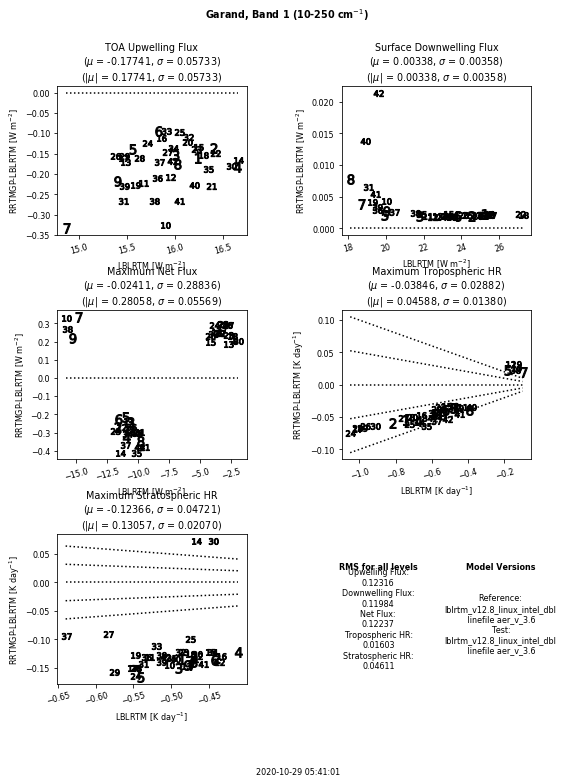

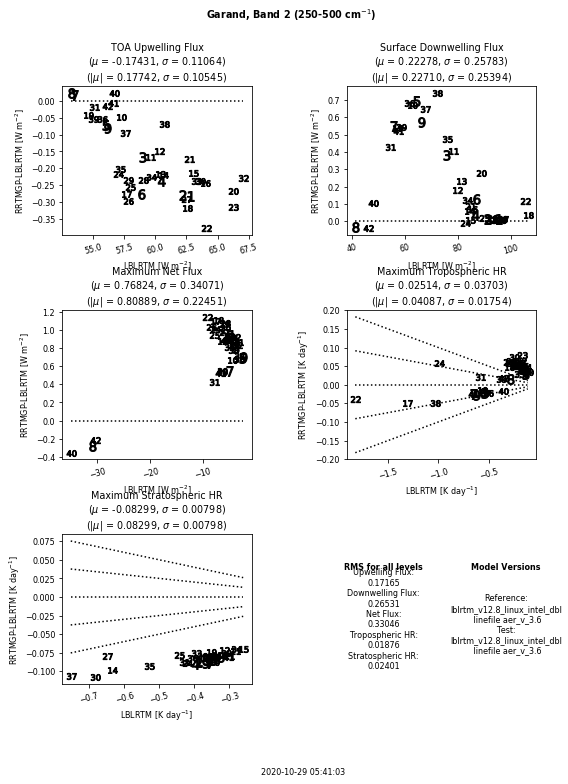

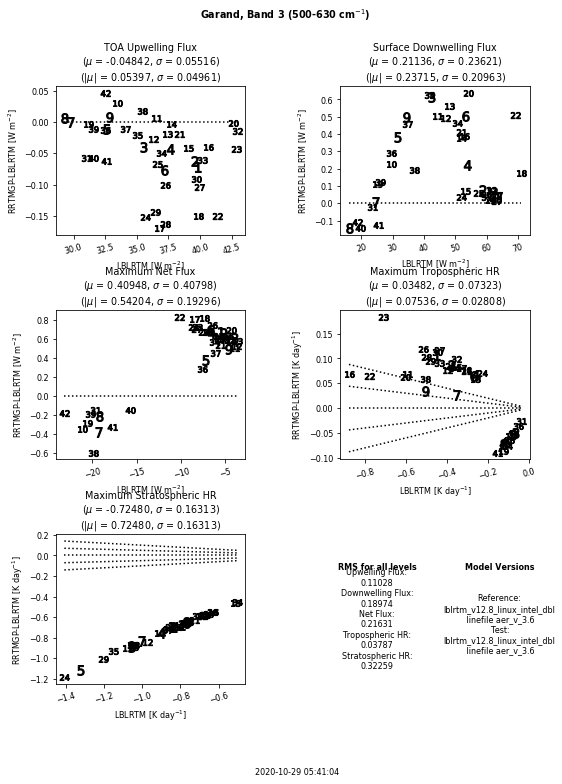

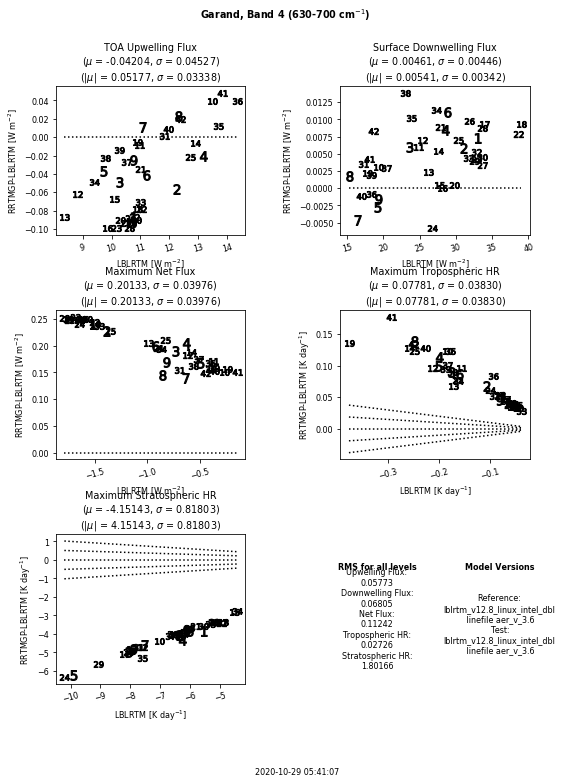

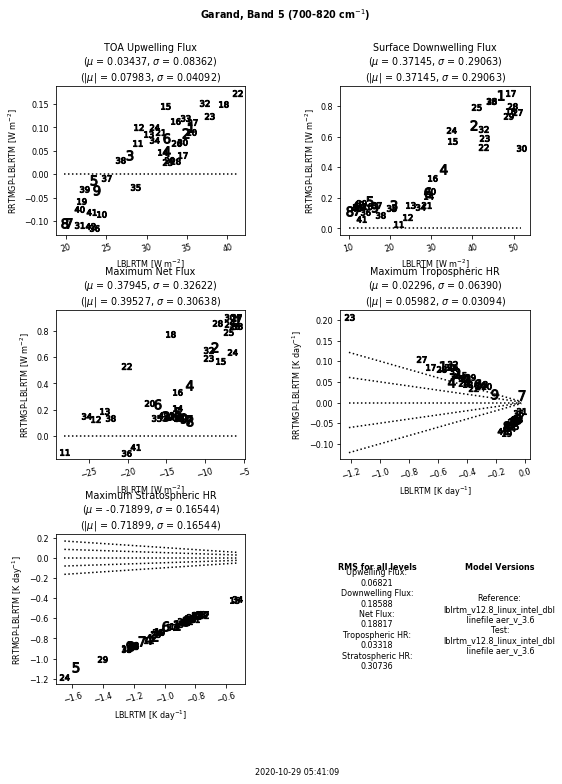

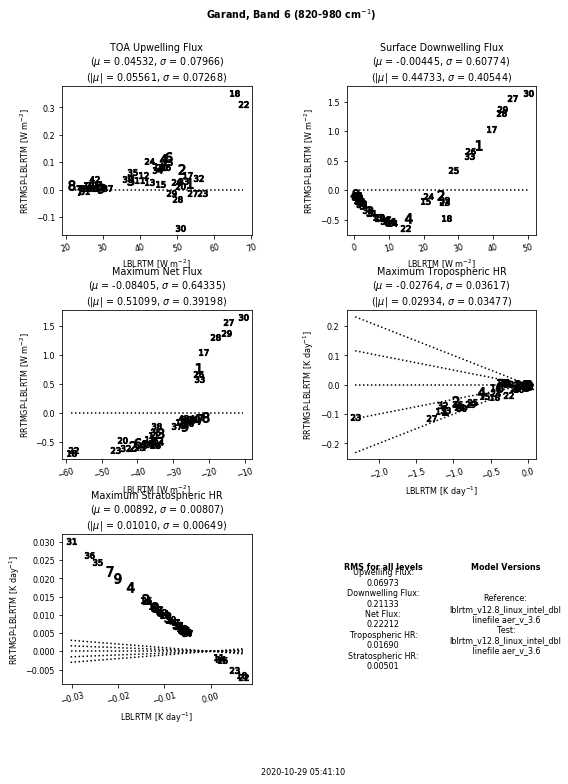

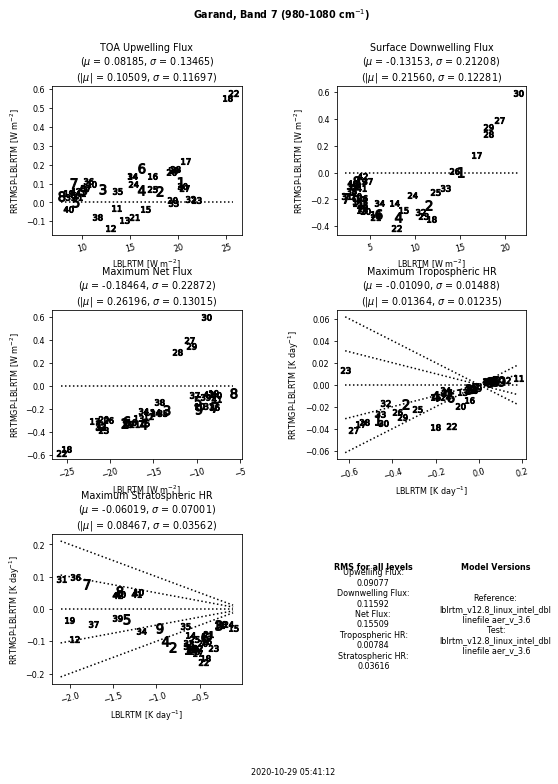

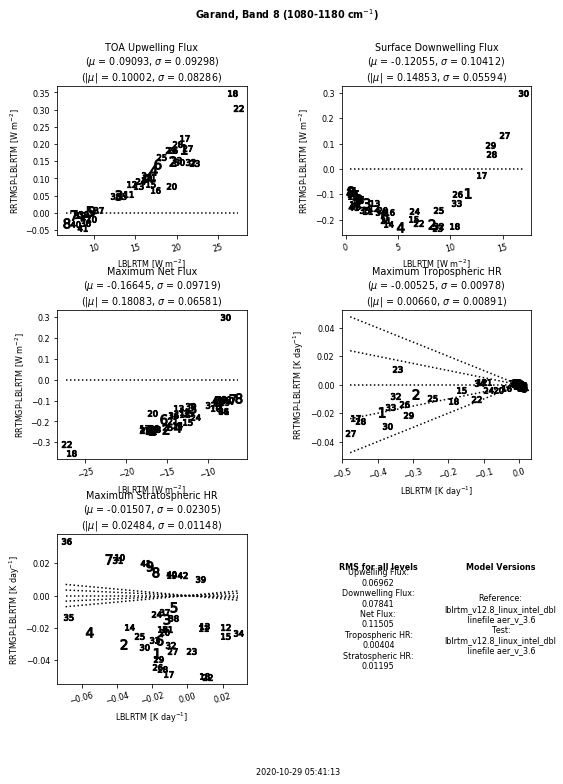

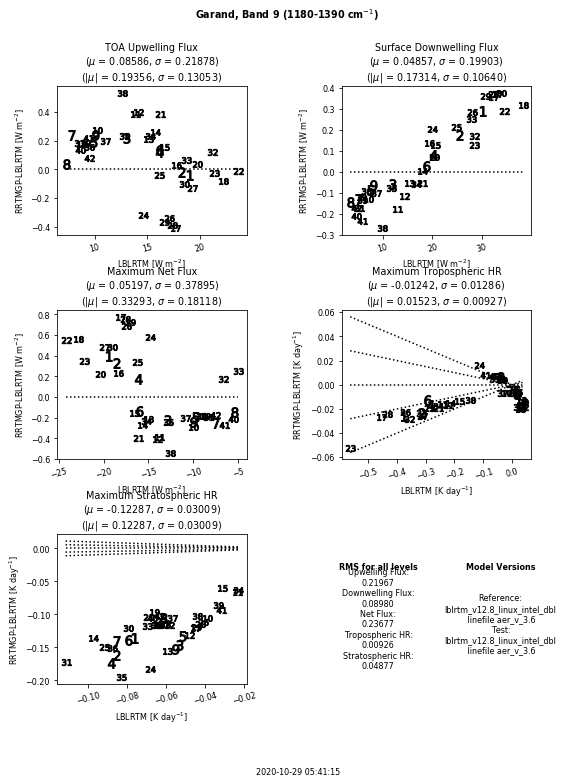

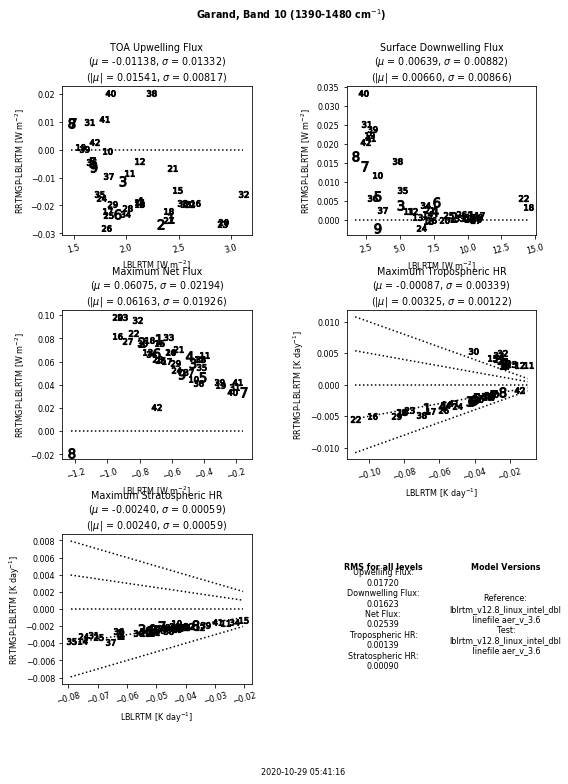

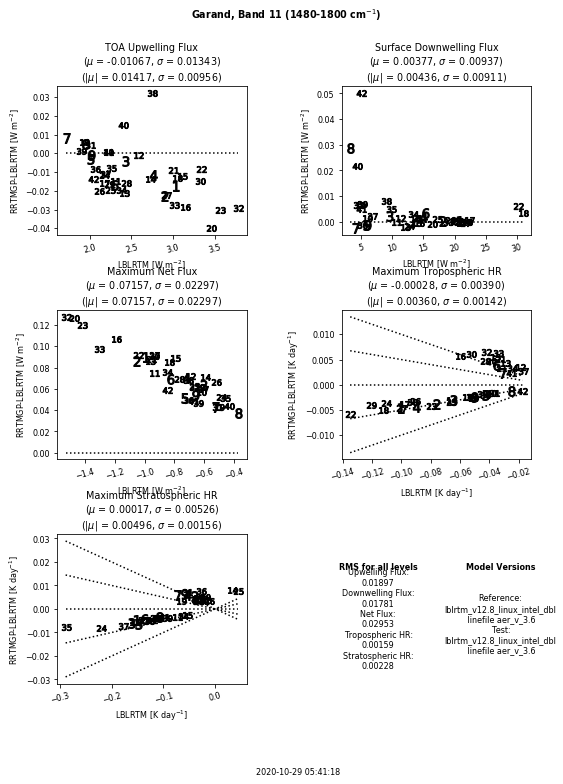

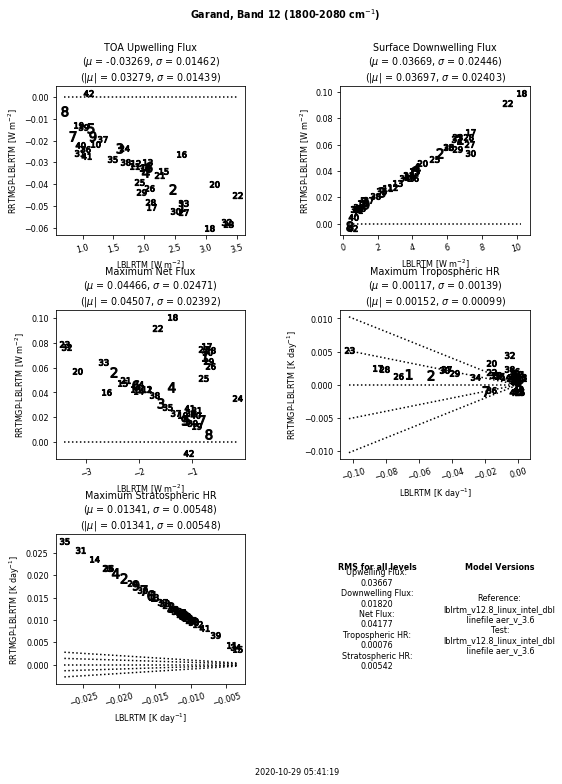

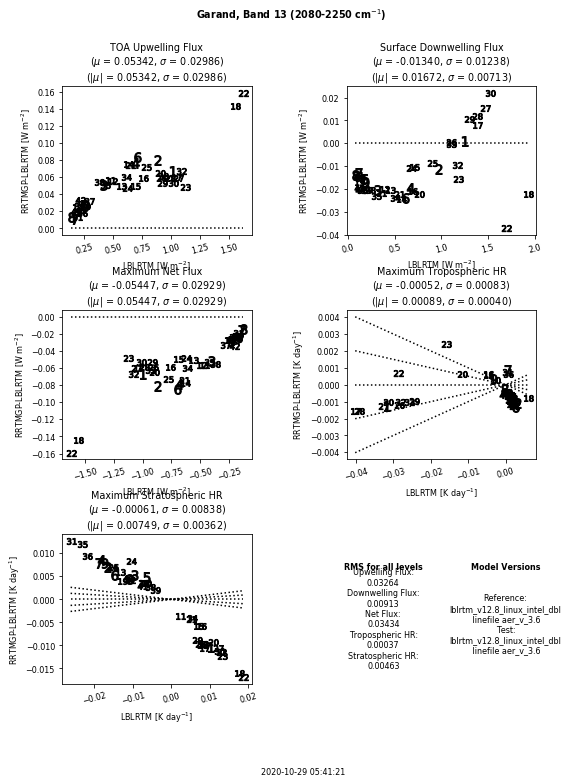

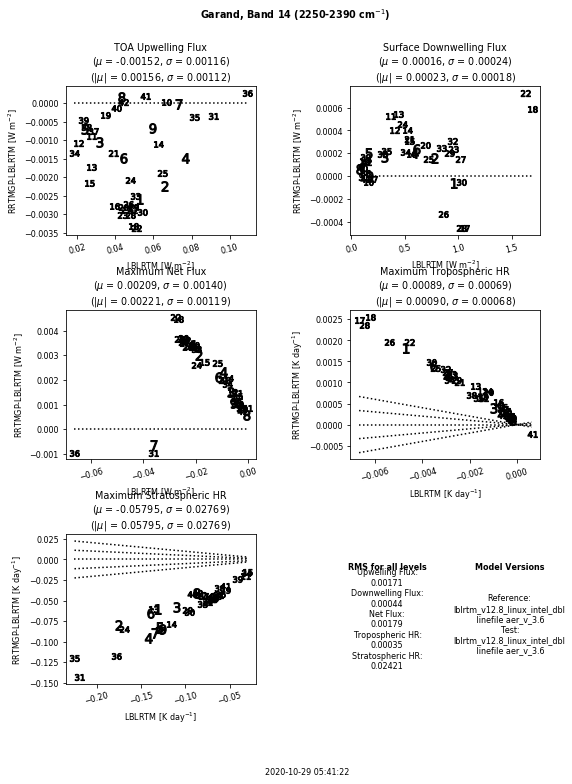

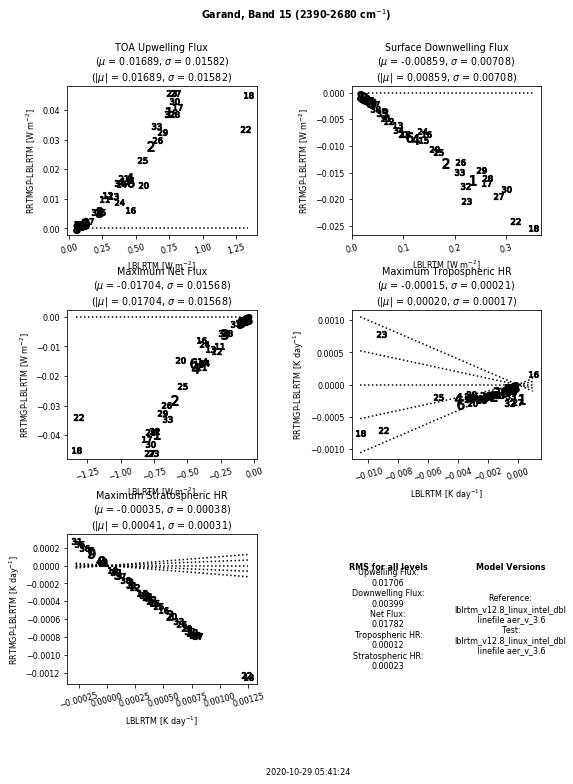

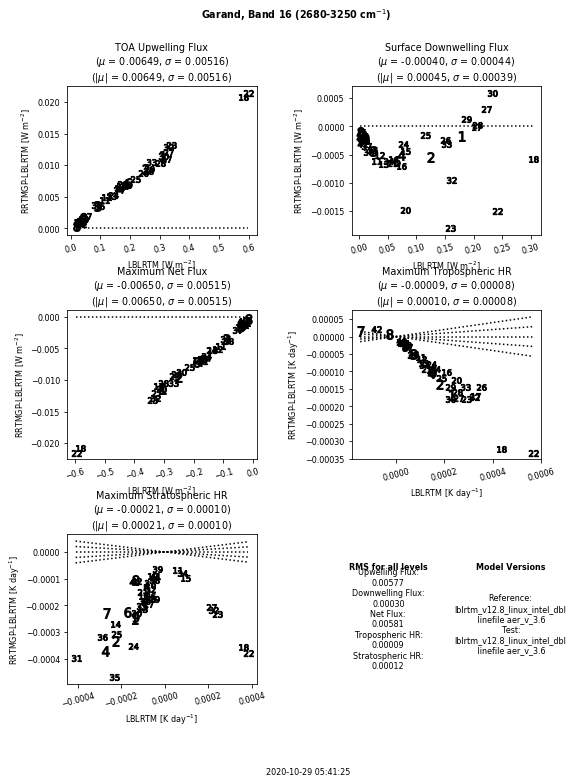

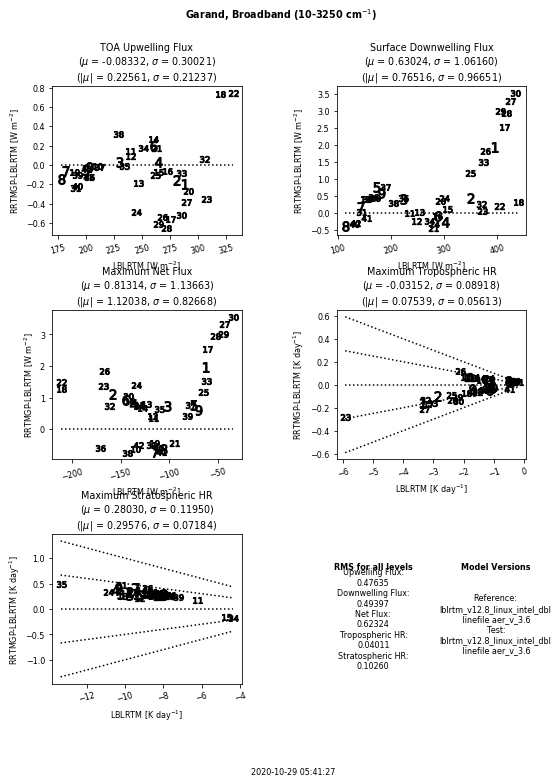

In [11]:
# plot profile statistics
if plot_stats:
    statPDF(refFile, testFile, singlePDF=single_stat, \
      tPauseP=pTrop, xTitle=xt, yTitle=yt, prefix=statPrefix, \
      atmType=aType, statCSV='', forcing=False)